In [1]:
import pandas as pd
import numpy as np
import Bio
import BCBio
from BCBio import GFF
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
pfam_clan = "/labs/mpsnyder/khoa/data/Pfam_Release37.2/Pfam-A.clans.tsv"
df_clan = pd.read_csv(pfam_clan, sep="\t", header=None)
df_clan.columns = ["pfam", "pclan", "acc_clan", "acc_fam", "desc"]

In [48]:
# fill missing values in the 'clan' column with pfam column
df_clan['pclan'] = df_clan['pclan'].fillna(df_clan['pfam'])

In [49]:
clan_fam_dict = dict(zip(df_clan['pfam'], df_clan['pclan']))

In [55]:
def generate_feature_vector(chunk, id_pclan_dict, feature_dict):
    for chunk in chunks:
        if chunk.type == "CDS":
            clans = id_pclan_dict.get(chunk.id, "unknown")
            for clan in clans:
                feature_dict[clan] += 1
        else:
            feature_dict[chunk.type] += 1
    return feature_dict

def get_feature_types(gff_file):
    # get all feature types from gff file
    feature_types = set()
    with open(gff_file) as infile:
        for record in GFF.parse(infile):
            for feature in record.features:
                feature_types.add(feature.type)
    return feature_types

def parse_gff_in_chunks(gff_file, chunk_size, stride):
    chunked_features = []

    with open(gff_file) as infile:
        for record in GFF.parse(infile):
            seq_len = max([int(feature.location.end) for feature in record.features], default=0)  # Get max feature position
            start_positions = list(range(0, seq_len, stride))  # Generate chunk start positions

            for start in start_positions:
                end = start + chunk_size
                chunk_features = [
                    feature for feature in record.features
                    if feature.location.start >= start and feature.location.start < end
                ]
                if chunk_features:
                    chunked_features.append(chunk_features)

    return chunked_features
    
def read_tsv_robust(file_path):
    with open(file_path, "r") as file:
        lines = [line.strip().split() for line in file if not line.startswith("#")]
    max_cols = max(len(row) for row in lines)
    padded_lines = [row + [None] * (max_cols - len(row)) for row in lines]
    df = pd.DataFrame(padded_lines)
    return df


In [56]:
gff_file = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.gff"
chunk_size = 500000000
stride = 100000000
chunked_features = parse_gff_in_chunks(gff_file, chunk_size, stride)
print(f"Number of chunks: {len(chunked_features)}")

Number of chunks: 7


In [57]:
# parse features keep only type and id (feature.type, feature.id)
chunked_features_parsed = []
for chunk in chunked_features:
    chunk_parsed = []
    for feature in chunk:
        chunk_parsed.append({
            "type": feature.type,
            "id": feature.id,
            "product": feature.qualifiers.get("product", [""])[0],
        })
    chunked_features_parsed.append(chunk_parsed)
print(f"Number of chunks parsed: {len(chunked_features_parsed)}")
print(chunked_features_parsed[:1])


Number of chunks parsed: 7
[[{'type': 'CDS', 'id': 'DFNOFNBE_00001', 'product': 'hypothetical protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00002', 'product': 'hypothetical protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00003', 'product': 'hypothetical protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00004', 'product': 'hypothetical protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00005', 'product': 'Acetoin catabolism regulatory protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00006', 'product': 'sn-glycerol-3-phosphate import ATP-binding protein UgpC'}, {'type': 'CDS', 'id': 'DFNOFNBE_00007', 'product': 'Trehalose import ATP-binding protein SugC'}, {'type': 'CDS', 'id': 'DFNOFNBE_00008', 'product': 'Melibiose/raffinose/stachyose import permease protein MelD'}, {'type': 'CDS', 'id': 'DFNOFNBE_00009', 'product': 'Diacetylchitobiose uptake system permease protein DasC'}, {'type': 'CDS', 'id': 'DFNOFNBE_00010', 'product': 'hypothetical protein'}, {'type': 'CDS', 'id': 'DFNOFNBE_00011', 'product': 'hypothetical p

In [58]:
pfam_out = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.PFAM"
df_pfam = read_tsv_robust(pfam_out)
df_pfam = df_pfam.iloc[:, :5]
df_pfam.columns = ["name", "pfam_acc", "id", "space", "evalue"]
df_pfam["pfam"] = df_pfam["pfam_acc"].apply(lambda x: x.split(".")[0] if pd.notna(x) else x)
df_pfam["clan"] = df_pfam["pfam"].map(clan_fam_dict)
df_pfam["evalue"] = df_pfam["evalue"].astype(float)
df_pfam = df_pfam[df_pfam["evalue"] < 0.01]
id_pclan_dict = df_pfam.groupby("id").agg({"clan":list}).to_dict()['clan']

In [70]:
df_product = pd.DataFrame(chunked_features_parsed[0])
df_product["pclan"] = df_product["id"].map(id_pclan_dict)
df_product["protein_annotated"] = df_product["product"].str.contains("hypothetical protein") * 1.
df_product["clan_annotated"] = df_product["pclan"].apply(lambda x: 1. if x is not None else 0.)
df_product["protein_annotated_mavg"] = df_product["protein_annotated"].rolling(window=10).mean()
df_product["clan_annotated_mavg"] = df_product["clan_annotated"].rolling(window=10).mean()

In [69]:
# plot moving average of protein annotated and clan annotated
fig, ax = plt.subplots()
df_product["protein_annotated_mavg"].plot(ax=ax, label="Protein annotated")
df_product["clan_annotated_mavg"].plot(ax=ax, label="Clan annotated")
plt.legend()


,type,id,product,pclan,protein_annotated,clan_annotated
0,CDS,DFNOFNBE_00001,hypothetical protein,NaN,1.0,1.0
1,CDS,DFNOFNBE_00002,hypothetical protein,NaN,1.0,1.0
2,CDS,DFNOFNBE_00003,hypothetical protein,NaN,1.0,1.0
3,CDS,DFNOFNBE_00004,hypothetical protein,NaN,1.0,1.0
4,CDS,DFNOFNBE_00005,Acetoin catabolism regulatory protein,"[CL0023, CL0023, CL0123, CL0123, CL0023, CL002...",0.0,1.0
...,...,...,...,...,...,...
5863,CDS,DFNOFNBE_05864,Peptidyl-prolyl cis-trans isomerase cyp18,[CL0475],0.0,1.0
5864,CDS,DFNOFNBE_05865,Glutamine--tRNA ligase,"[CL0039, CL0733, CL0733]",0.0,1.0
5865,CDS,DFNOFNBE_05866,Cysteine--tRNA ligase,"[CL0039, CL0258, CL0039, PF23493, CL0039, CL0039]",0.0,1.0
5866,CDS,DFNOFNBE_05867,putative protein YyaP,[CL0387],0.0,1.0


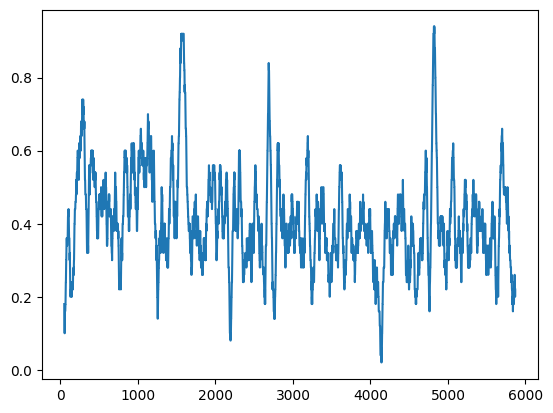

In [40]:
# apply moving average to the unannotated column
window_size = 50
df_product["unannotated_ma"] = df_product["unannotated"].rolling(window=window_size).mean()
plt.plot(df_product["unannotated_ma"])

In [81]:
unknown_set = set("unknown")
clan_set = set(df_clan.pclan)
feature_types = get_feature_types(gff_file)
# combine clan_set and feature_types
combined_set = clan_set.union(feature_types).union(unknown_set)
feature_dict = {}
for feature in combined_set:
    feature_dict[feature] = 0